In [1]:
get_ipython().run_line_magic('matplotlib', 'widget')

In [2]:
pip install rocketcea

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install jsonpickle

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install windrose

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install simplekml

Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install --upgrade cffi

In [9]:
pip install --upgrade rocketpy

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install timezonefinder

Note: you may need to restart the kernel to use updated packages.


In [11]:
from rocketpy import Environment, Rocket, LiquidMotor, Flight

In [12]:
import rocketcea
import os
import numpy as np
import scipy
from scipy.optimize import minimize
import tkinter as tk  
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.matplotlib_fname())
from rocketcea.cea_obj import CEA_Obj
import pandas as pd
import math 
import datetime

class propellant:
    def __init__(self,name, density, viscosity,tank_length, tank_radius, temperature):
        self.density = density
        self.viscosity = viscosity
        self.temp = temperature
        self.rad = tank_radius
        self.length = tank_length
        self.name = name
        return None
    def __str__(self) -> str:
        return self.name

/opt/conda/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


In [13]:
%matplotlib widget

In [14]:
env = Environment(
    latitude=32.9901, 
    longitude=-106.9751, 
    elevation=1400.556
)

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date(
  (tomorrow.year, tomorrow.month, tomorrow.day, 12), timezone="America/Denver"
) # Tomorrow's date in year, month, day, hour UTC format

env.set_atmospheric_model(type='Forecast', file='GFS')

oc_open: server error retrieving url: code=0 message="/gfs_0p25/gfs20230830/gfs_0p25_18z is not an available dataset"

In [15]:
#env.info()

/tmp/ipykernel_111/3876605346.py:60: RuntimeWarning: invalid value encountered in double_scalars
  mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - Pc_test[i]))**(1/2)


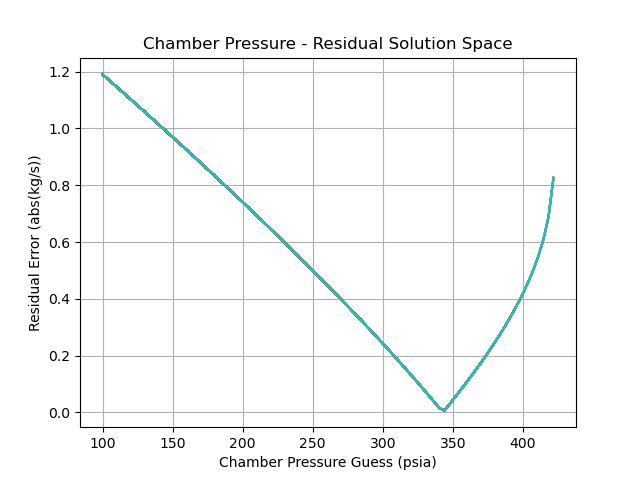

In [16]:
#Fluid Properties (SI units)
rho_LOX = 1140.0
rho_ETH = 798.0

#System Test Data Results
CdA_inj_LOX = 0.00001134 #faked for testing
CdA_inj_ETH = 0.00001078 #faked for testing

CdA_feed_LOX = 0.0000305333 #faked for testing
CdA_feed_ETH = 0.0000244267 #faked for testing

#Hydraulic Resistance Terms
R_ox_inj = 1/(2*(CdA_inj_LOX**2)) #dP=Rhyd*mdot^2/rho
R_eth_inj = 1/(2*(CdA_inj_ETH**2)) #dP=Rhyd*mdot^2/rho

R_ox_feed = 1/(2*(CdA_feed_LOX**2)) #dP=Rhyd*mdot^2/rho
R_eth_feed = 1/(2*(CdA_feed_ETH**2)) #dP=Rhyd*mdot^2/rho

R_ox = R_ox_inj + R_ox_feed #Equivalent Hydraulic System Resistance
R_eth = R_eth_inj + R_ox_feed #Equivalent Hydraulic System Resistance

#Tank Properties
gamma_tanks = 1.41 #1.41=GN2, 1.67=GHe
V_oxtank = 6.92655 #L
V_ethtank = 7.57 #L

V_oxinit = 3.25 #OPTMIMIZE THIS
V_ethinit = 3.0 #OPTIMIZE THIS

V_oxgas = V_oxtank-V_oxinit
V_ethgas = V_ethtank - V_ethinit

#Initial Tank Pressures
P_tank_ox_psi = 475.0 #psia
P_oxtank = P_tank_ox_psi*6895 #Pa

P_tank_eth_psi = 425.0 #psia
P_ethtank = P_tank_eth_psi*6895 #Pa

#define cstar efficiency: completeion of energy release. See RPE Pg64
Efficiency = 0.925
chamber = CEA_Obj(propName="", oxName="LOX", fuelName="C2H5OH") #initializs CEA object

#define Throat Diameter, Area
Dt = 26.04/1000 #m
At = (Dt**2)/4*math.pi

# Initialize Array
Residual = []

#create Chamber Pressure Guess Array
Pc_test_psi = np.linspace(100.0, 450.0, 100) #psia
Pc_test = Pc_test_psi*6895 #Pa

#solve residual for each pressure guess
for i in range(len(Pc_test)):
    
    #solve mass flow from fluid resistances
    mdot_ox = ((1/R_ox)*rho_LOX*(P_oxtank - Pc_test[i]))**(1/2)
    mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - Pc_test[i]))**(1/2)
    mdot_fluid = mdot_ox + mdot_eth
    #get OF ratio
    OF_ratio_test = mdot_ox/mdot_eth

    #solve mass flow from CEA 
    Cstar_fps = chamber.get_Cstar(Pc=Pc_test_psi[i], MR=OF_ratio_test) #see RPE pg64
    Cstar = Cstar_fps*0.3048 #m
    mdot_CEA = Pc_test[i]*At/(Cstar*Efficiency) #kg/s

    #compare residual, append to array
    error = mdot_CEA-mdot_fluid
    Residual.append(abs(error))
    
    plt.plot(Pc_test_psi[:i+1], Residual[:i+1])
    plt.xlabel('Chamber Pressure Guess (psia)')
    plt.ylabel('Residual Error (abs(kg/s))')
    plt.title('Chamber Pressure - Residual Solution Space')
    plt.grid(True)

    
# Display the final plot after the loop
plt.show()

def Calculate_Residual(Pc, P_oxtank, P_ethtank):
    #solve mass flow from fluid resistances
    mdot_ox = ((1/R_ox)*rho_LOX*(P_oxtank - (Pc*6895)))**(1/2)
    mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - (Pc*6895)))**(1/2)
    mdot_fluid = mdot_ox + mdot_eth
    #get OF ratio
    OF_ratio = mdot_ox/mdot_eth
    #solve mass flow from CEA 
    Cstar_fps = chamber.get_Cstar(Pc = Pc[0], MR = OF_ratio[0]) #see RPE pg64
    Cstar = float(Cstar_fps*0.3048) #m/s
    if Cstar == 0:
        print("CSTAR ZERO")
        print(f"PC = {Pc[0]}")
        mdot_CEA_res = Pc*6895*At/(abs(Cstar)*Efficiency)
    else:
        mdot_CEA_res = (Pc*6895)*At/(Cstar*Efficiency) #kg/s

    #compare residual, append to array
    error = mdot_CEA_res-mdot_fluid
    
    global OF_ratio_glob
    OF_ratio_glob = float(OF_ratio[0])

    global mdot_total_glob
    mdot_total_glob = float(mdot_fluid[0])

    if OF_ratio > 1.8: #tank pressure drop eqs breaking
        error = 500

    return abs(error)

def GradientDescent(guess, P_oxtank, P_ethtank):
    # Use scipy optimize minimize with residual function to find Chamber Pressure
    result = minimize(
        Calculate_Residual,
        guess,
        args = (P_oxtank, P_ethtank),
        bounds = [(100, min([P_oxtank/6895, P_ethtank/6895]))],
    )
    P_chamber = result.x[0]
    # t = type(P_chamber)
    #print(f"Pchamb TYPE {t}")
    OF = OF_ratio_glob
    isp = chamber.estimate_Ambient_Isp(Pc=P_chamber,MR=OF,eps=4.35)[0]
    thrust = 9.8*isp*(mdot_total_glob)/1000 #kN
    print(f"Thrust {thrust}")
    massflow_total = mdot_total_glob
    print(f"massflow {massflow_total}")
    #print(f"PC {P_chamber/6895} and MR {OF_ratio} at {i*dt}")

    return P_chamber, thrust, OF, massflow_total


TIMESTEP 0.10050251256281408
Thrust 1.9787652247250116
massflow 0.7903713507625868
Oxtank = 467.3243503261677[psi] ... Ethtank = 420.001692256789[psi] at 0.0
Thrust 1.9523627250035096
massflow 0.7813058140641851
Oxtank = 459.9645798039857[psi] ... Ethtank = 413.98681064002295[psi] at 0.10050251256281408
Thrust 1.9252484042064868
massflow 0.7717953527088681
Oxtank = 452.88957824945993[psi] ... Ethtank = 408.1905511424286[psi] at 0.20100502512562815
Thrust 1.8990367129023915
massflow 0.7626006277550317
Oxtank = 446.0822295855803[psi] ... Ethtank = 402.60037684600826[psi] at 0.30150753768844224
Thrust 1.8736788541716611
massflow 0.7537046189032806
Oxtank = 439.5267952072465[psi] ... Ethtank = 397.2047223427037[psi] at 0.4020100502512563
Thrust 1.8491299381323363
massflow 0.7450915925355786
Oxtank = 433.2087761080565[psi] ... Ethtank = 391.9928994169013[psi] at 0.5025125628140704
Thrust 1.8253480811546725
massflow 0.7367469302428156
Oxtank = 427.1147917250549[psi] ... Ethtank = 386.9550140

/tmp/ipykernel_111/3876605346.py:90: RuntimeWarning: divide by zero encountered in true_divide
  OF_ratio = mdot_ox/mdot_eth
/tmp/ipykernel_111/3876605346.py:97: RuntimeWarning: divide by zero encountered in true_divide
  mdot_CEA_res = Pc*6895*At/(abs(Cstar)*Efficiency)


CSTAR ZERO
PC = 337.28304250450424
Thrust 1.5713954086180077
massflow 0.6475872683194372
Oxtank = 363.6887955880044[psi] ... Ethtank = 333.8618377367459[psi] at 1.9095477386934674
Thrust 1.5552411490995557
massflow 0.6419121428871813
Oxtank = 359.75696176679963[psi] ... Ethtank = 330.5294104983654[psi] at 2.0100502512562817
Thrust 1.5394736122515327
massflow 0.6363724379267188
Oxtank = 355.93120868582236[psi] ... Ethtank = 327.28210500711447[psi] at 2.1105527638190957
Thrust 1.5240778248130715
massflow 0.6309629015305069
Oxtank = 352.20705075119383[psi] ... Ethtank = 324.1164699999366[psi] at 2.21105527638191
CSTAR ZERO
PC = 324.1164699899366
Thrust 1.509039613659609
massflow 0.625678562218906
Oxtank = 348.5802581304434[psi] ... Ethtank = 321.0292443695575[psi] at 2.311557788944724
Thrust 1.494345402194958
massflow 0.620514701051985
Oxtank = 345.04683856642185[psi] ... Ethtank = 318.0173440554035[psi] at 2.412060301507538
Thrust 1.479982386941574
massflow 0.6154668483420302
Oxtank = 34

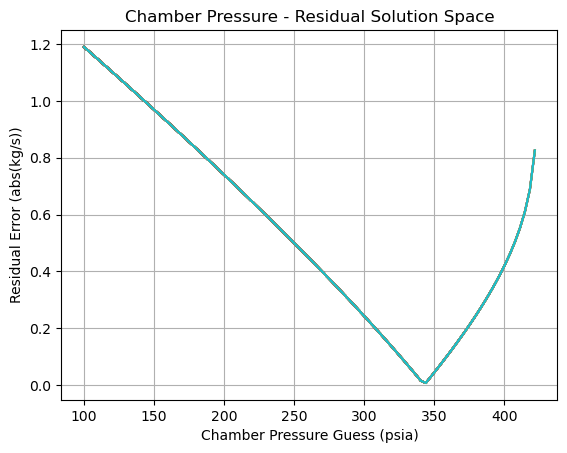

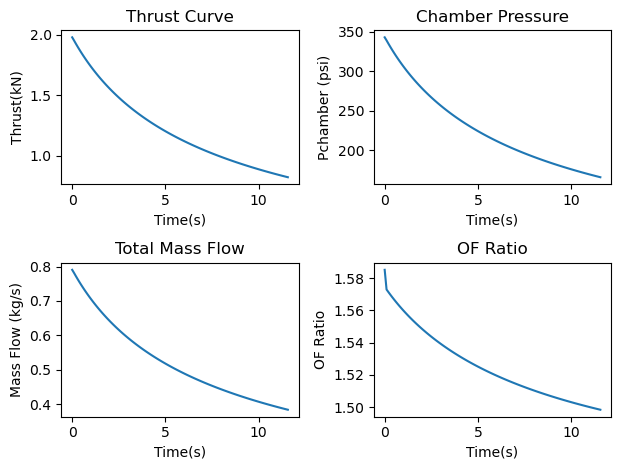

In [17]:
#reference thrust curve
iterations = 200
time = np.linspace(0, 20, iterations) #200 pts from 0 to 15 seconds
dt = float(time[1]-time[0])
print(f"TIMESTEP {dt}")
OF_array = []
Thrust_array = []
P_chamber_array = []
mdtot_array = []
fin = 0
for i in range(len(time)): #perform this for every timestep in the profile

    if i == 0:
        Pc_guess = 350
    else:
        Pc_guess = P_chamber_last-5
    
    P_chamber, Thrust, OF, md_tot = GradientDescent(Pc_guess, P_oxtank, P_ethtank)
    md_ox = md_tot/(
        1+1/OF) 
    md_eth = md_tot-md_ox
    
    #print(f"Timestep {dt}")
    masslost_ox = md_ox*dt
    masslost_eth = md_eth*dt
    #print(f"masslostox {masslost_ox}")
    
    #print(f"Voxgas(L) {V_oxgas}")
    V_oxgas_next = V_oxgas + (masslost_ox/(rho_LOX*0.001))
    V_ethgas_next = V_ethgas + (masslost_eth/(rho_ETH*0.001))
    #print(f"Voxgasnext(L) {V_oxgas_next}")

    P_oxtank = P_oxtank*((V_oxgas/V_oxgas_next)**gamma_tanks)
    P_ethtank = P_ethtank*((V_ethgas/V_ethgas_next)**gamma_tanks)
    print(f"Oxtank = {P_oxtank/6895}[psi] ... Ethtank = {P_ethtank/6895}[psi] at {i*dt}")

    V_oxgas = V_oxgas_next
    V_ethgas = V_oxgas_next

    mdtot_array.append(md_tot)
    OF_array.append(OF)
    Thrust_array.append(Thrust)
    P_chamber_array.append(P_chamber)
    assert len(Thrust_array) == len(P_chamber_array)
    P_chamber_last = P_chamber

    if P_chamber>(0.90*P_oxtank/6895) or P_chamber>(0.90*P_oxtank/6895):
        OxDrop = (P_oxtank/6895)/P_chamber
        ETHDrop = (P_ethtank/6895)/P_chamber
        print(f"Flow Stability Violated with {OxDrop}% LOXratio and {ETHDrop}% ETHratio")
        break

    if V_oxgas>=(V_oxtank-V_oxtank/250) or V_ethgas>=(V_ethtank-V_ethtank/250):
        oxrem = V_oxtank-V_oxgas
        ethrem = V_ethtank-V_ethgas
        print(f"Burn finished with {oxrem}L LOX and {ethrem}L ETH at Time {i*dt}s")
        break
        
# Create the subplots and plot the data
fig, axs = plt.subplots(2, 2)
sc = axs[0, 0].plot(time[0:len(Thrust_array)], Thrust_array)
axs[0, 0].set_title("Thrust Curve")
axs[0, 0].set_xlabel("Time(s)")
axs[0, 0].set_ylabel("Thrust(kN)")

axs[0, 1].plot(time[0:len(Thrust_array)], P_chamber_array)
axs[0, 1].set_title("Chamber Pressure")
axs[0, 1].set_xlabel("Time(s)")
axs[0, 1].set_ylabel("Pchamber (psi)")

axs[1, 0].plot(time[0:len(Thrust_array)], mdtot_array)
axs[1, 0].set_title("Total Mass Flow")
axs[1, 0].set_xlabel("Time(s)")
axs[1, 0].set_ylabel("Mass Flow (kg/s)")

axs[1, 1].plot(time[0:len(Thrust_array)], OF_array)
axs[1, 1].set_title("OF Ratio")
axs[1, 1].set_xlabel("Time(s)")
axs[1, 1].set_ylabel("OF Ratio")

# Adjust layout
plt.tight_layout()

# WRITE TO .ENG FILE
file_path = "data/motors/LE2.eng"  # Specify the desired file path

if not os.path.exists(file_path):
    f = open(file_path, "x")
    f.close()

# Open the file for writing
with open(file_path, "w") as f:
    f.write("; ALULA - LE2 \n")
    f.write("; 8/1/2023 ver. \n")
    f.write("; created by UCB STAR \n")
    f.write("LE2 98 732 0 6.325 8.98822 ALULA\n")  

    for i in range(len(Thrust_array)):
        f.write(f"{str(time[i])} {str(Thrust_array[i] * 1000)}\n")  # Thrust_array values in N

# Display the plots
%matplotlib inline
plt.show()

In [18]:
LE2 = LiquidMotor(    
            thrust_source="../RocketPy-100a1/data/motors/LE2.eng",
            dry_mass=12.685,
            center_of_dry_mass=1.107,
            dry_inertia=(7.332,7.333,0.0318,-0.00153,0.0219,0.0284),
            nozzle_radius=0.0515/2,
           # burn_time,
            nozzle_position=0,
            reshape_thrust_curve=False,
            interpolation_method="linear",
            coordinate_system_orientation="nozzle_to_combustion_chamber",
)

Nozzle Details
Nozzle Radius: 0.02575 m

Motor Details
Total Burning Time: 11.557788944723619 s
Total Propellant Mass: 8.236 kg
Average Propellant Exhaust Velocity: nan m/s
Average Thrust: 1208.320 N
Maximum Thrust: 1952.3627250035097 N at 0.10050251256281408 s after ignition.
Total Impulse: 13965.504 Ns



/home/jovyan/RocketPy-100a1/rocketpy/Function.py:2178: RuntimeWarning: divide by zero encountered in double_scalars
  return Function(lambda x: (self.get_value_opt(x) / other(x)))
/home/jovyan/RocketPy-100a1/rocketpy/Function.py:2487: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  ans, _ = integrate.quad(self, a, b, epsabs=0.001, limit=10000)


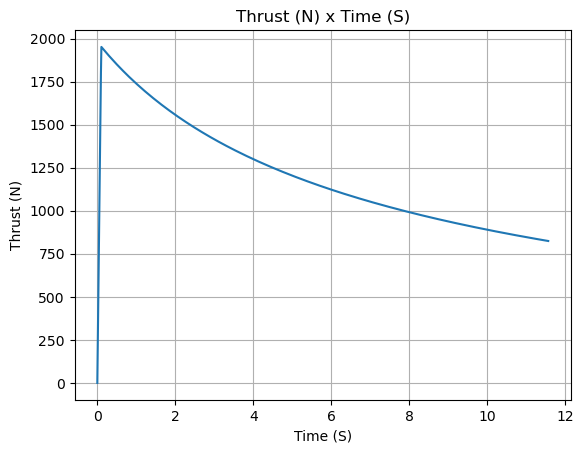

In [19]:
LE2.info()

In [20]:
ALULA = Rocket(
        #self,
        radius=0.0785,
        mass=23.347,     #  without motor -> total dry: 36.038kg
        inertia=(40.32089762,40.32707615,0.16968255,-0.00501791,-0.33114339,0.44168709),
        power_off_drag="../RocketPy-100a1/data/Alula_Cd_PowerOn.csv", ##UPDATE
        power_on_drag="../RocketPy-100a1/data/Alula_Cd_PowerOff.csv", ##UPDATE
        center_of_mass_without_motor=1.996, 
        coordinate_system_orientation="tail_to_nose",
)

railButtons = ALULA.set_rail_buttons(
    upper_button_position=0.18,
    lower_button_position=-1.4246,
    angular_position=60,
)

ALULA.add_motor(LE2, position=0) # origin = nozzle outlet

NoseCone = ALULA.add_nose(length=0.762, kind="vonKarman", position=3.99) 

FinSet = ALULA.add_trapezoidal_fins(
    n=3,
    root_chord =0.305,
    tip_chord=0.102,
    span=0.152,
    position=0.4,
    sweep_angle=33.7
)

In [21]:
ALULA.info()


Inertia Details

Rocket Mass: 23.347 kg (No Propellant)
Rocket Mass: 44.269 kg (With Propellant)
Rocket Inertia (with motor, but without propellant) 11: 54.149 kg*m2
Rocket Inertia (with motor, but without propellant) 22: 54.156 kg*m2
Rocket Inertia (with motor, but without propellant) 33: 0.201 kg*m2
Rocket Inertia (with motor, but without propellant) 12: -0.007 kg*m2
Rocket Inertia (with motor, but without propellant) 13: -0.309 kg*m2
Rocket Inertia (with motor, but without propellant) 23: 0.470 kg*m2


Geometrical Parameters

Rocket Maximum Radius: 0.0785 m
Rocket Frontal Area: 0.019359 m2

Rocket Distances
Rocket Center of Dry Mass - Nozzle Exit Distance: 1.683 m
Rocket Center of Dry Mass - Center of Propellant Mass: 1.683 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.313 m

Aerodynamic Components Parameters
Currently not implemented.


Aerodynamics Lift Coefficient Derivatives

Nosecone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 6.707/rad

In [22]:
#ALULA.parachutes.remove(drogue)
#ALULA.parachutes.remove(main)

In [23]:
main = ALULA.add_parachute(
    name="main", #120''d
    cd_s=7.07050353*2.2,
    trigger=457.2,  # ejection altitude: 1500ft
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

drogue = ALULA.add_parachute(
    name="drogue", #60''d
    cd_s=1.767638271*2.2,
    trigger="apogee",  # ejection at apogee
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

## Flight Results

In [24]:
test_flight = Flight(
  rocket=ALULA, environment=env, rail_length=18.288, inclination=85, heading=0
)


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1471.33 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 5.43 m/s
Lateral Surface Wind Speed: -1.10 m/s


Launch Rail

Launch Rail Length: 18.288  m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 1.064 s
Rail Departure Velocity: 31.815 m/s
Rail Departure Static Margin: 1.960 c
Rail Departure Angle of Attack: 10.008°
Rail Departure Thrust-Weight Ratio: 3.974
Rail Departure Reynolds Number: 2.653e+05


Burn out State

Burn out time: 11.558 s
Altitude at burn out: 1343.991 m (AGL)
Rocket velocity at burn out: 182.371 m/s
Freestream velocity at burn out: 182.424 m/s
Mach Number at burn out: 0.535
Kinetic energy at burn 

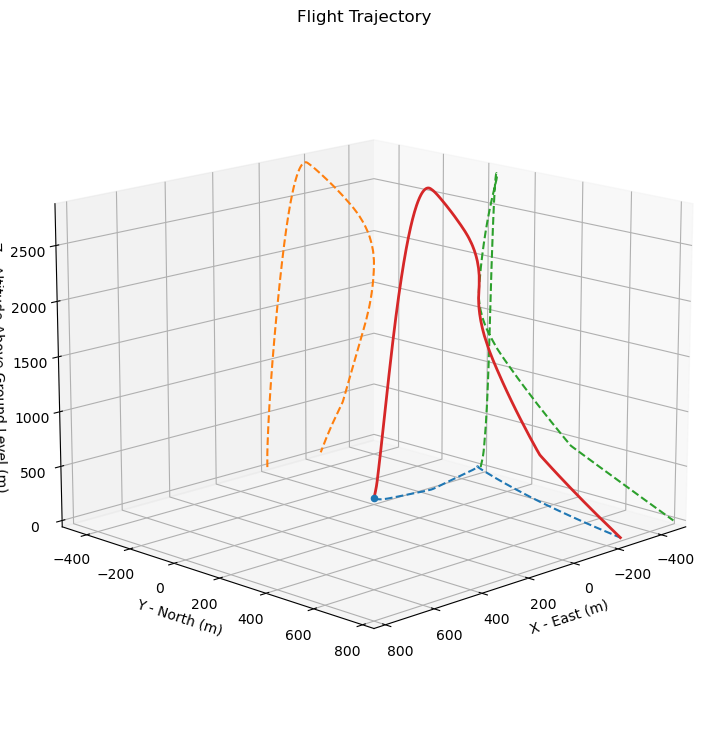



Trajectory Kinematic Plots



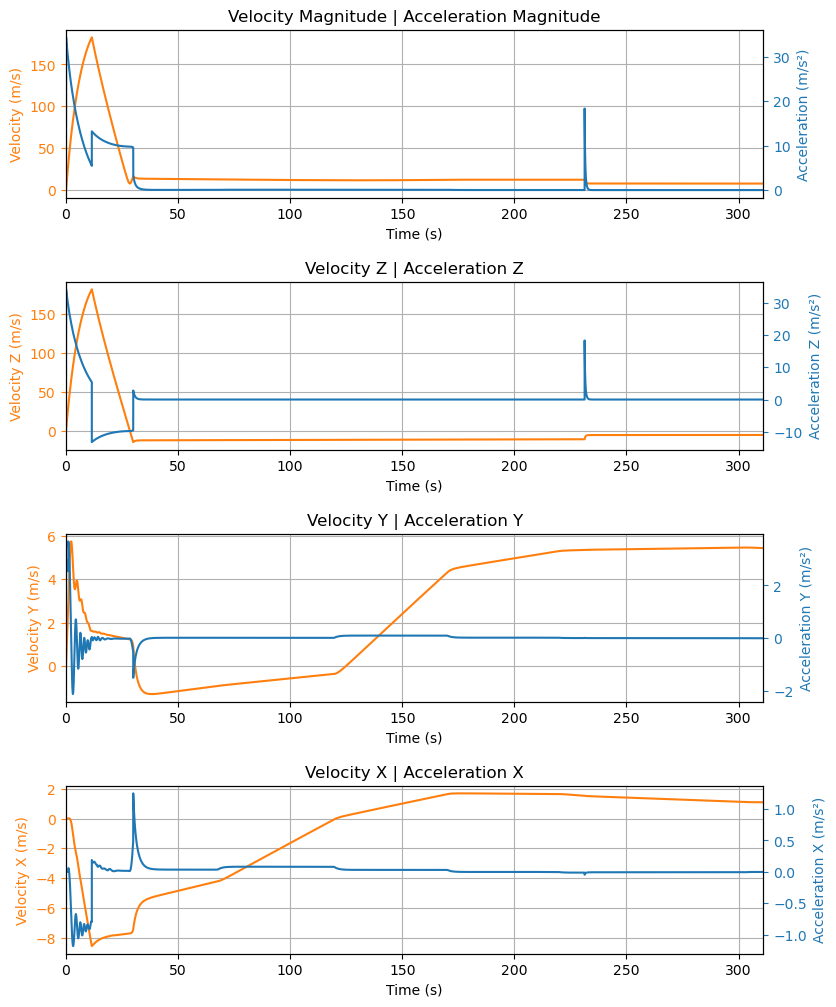



Angular Position Plots



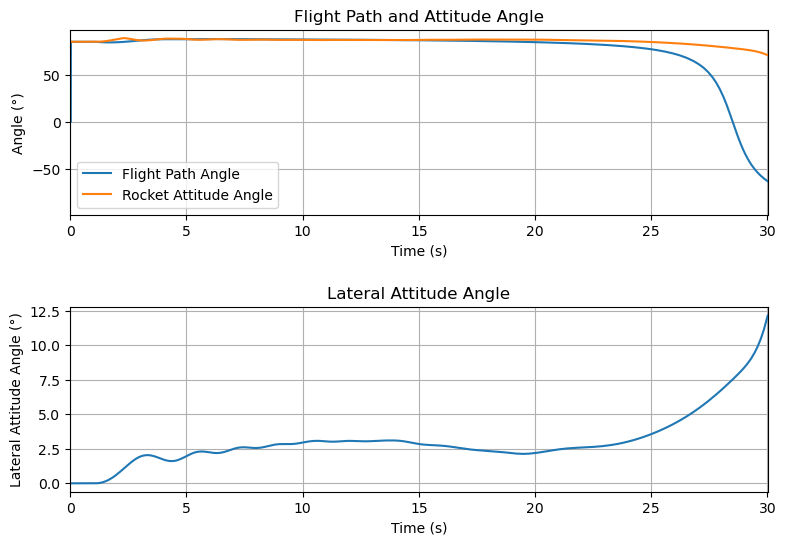



Path, Attitude and Lateral Attitude Angle plots



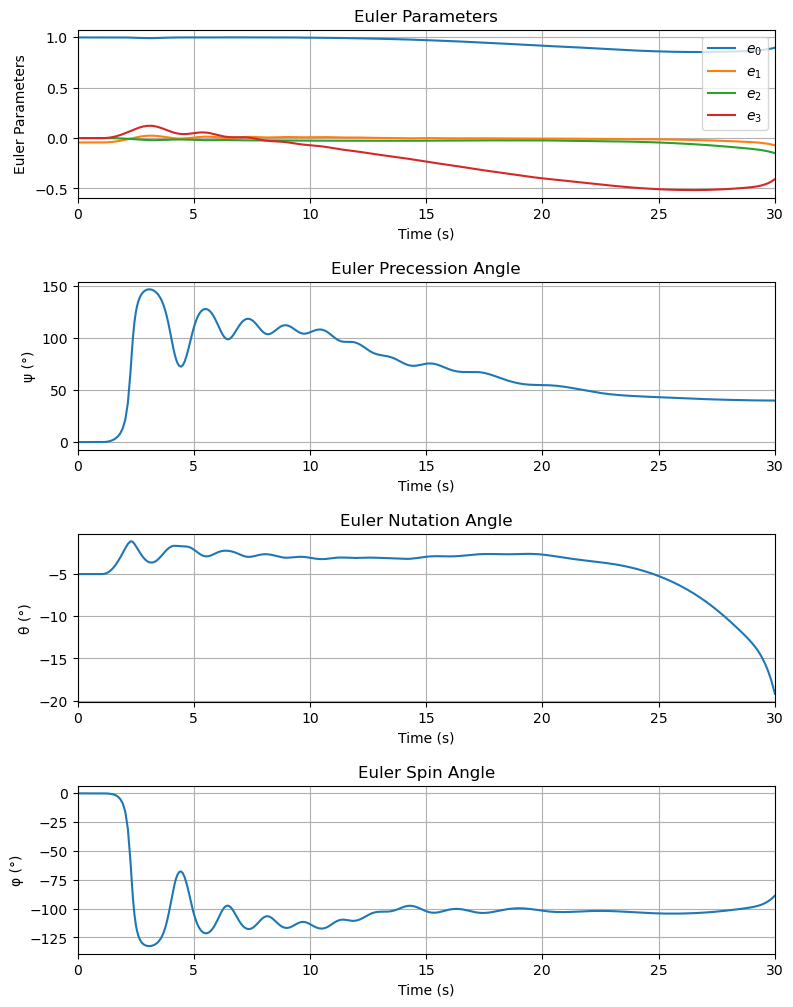



Trajectory Angular Velocity and Acceleration Plots



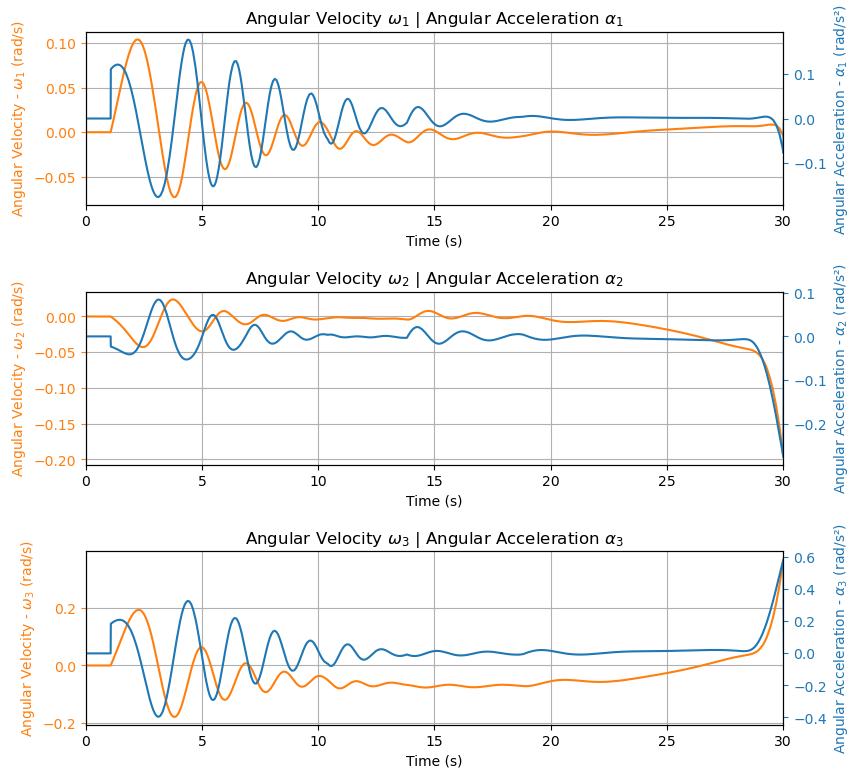



Aerodynamic Forces Plots



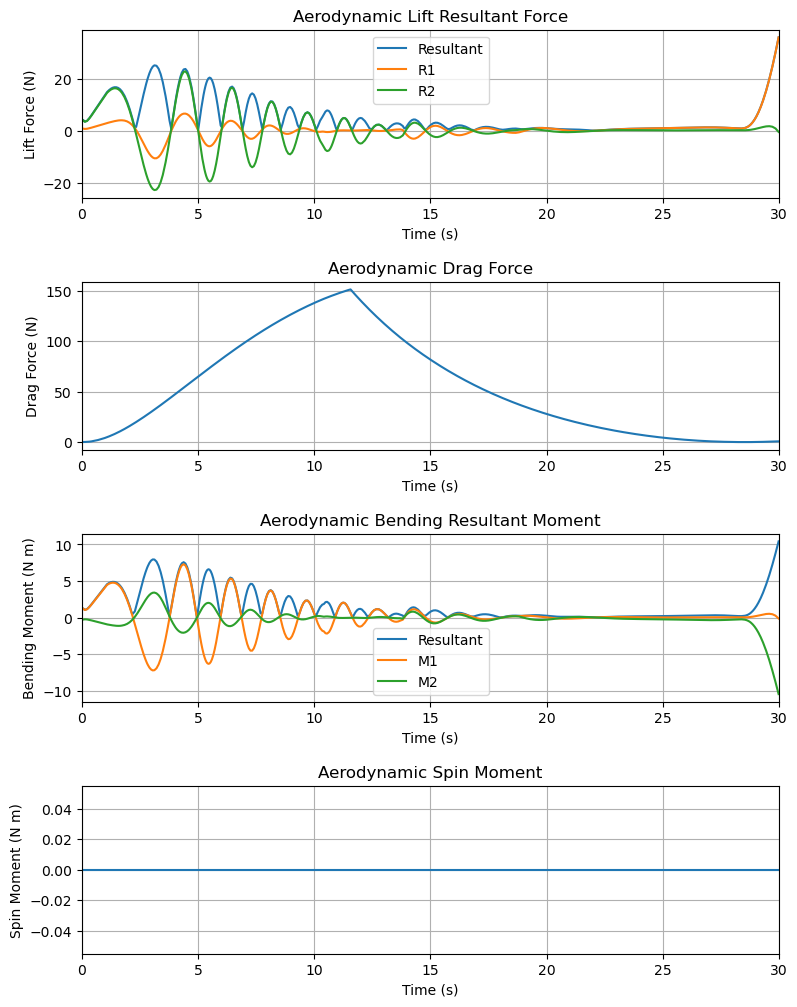



Rail Buttons Forces Plots



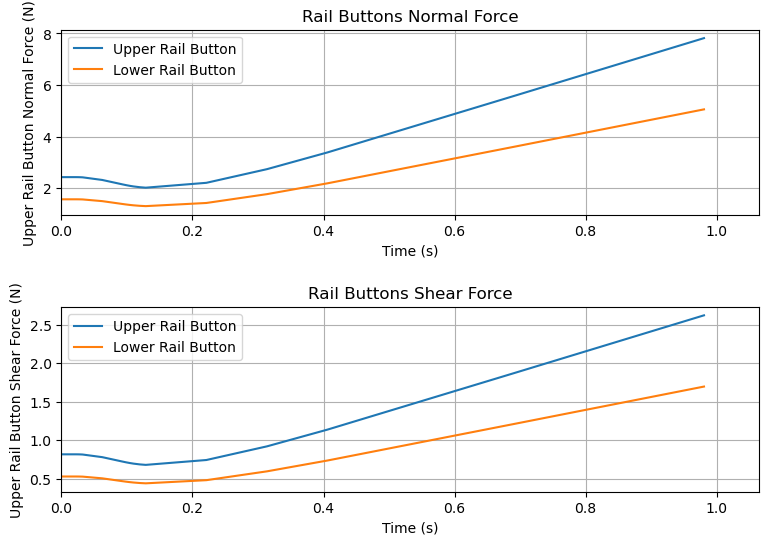



Trajectory Energy Plots



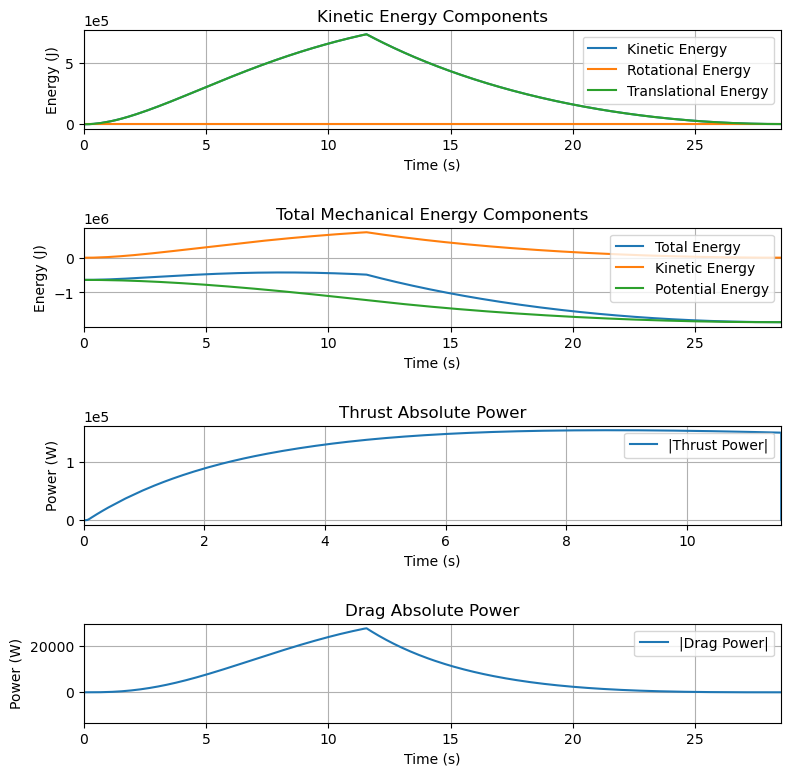



Trajectory Fluid Mechanics Plots



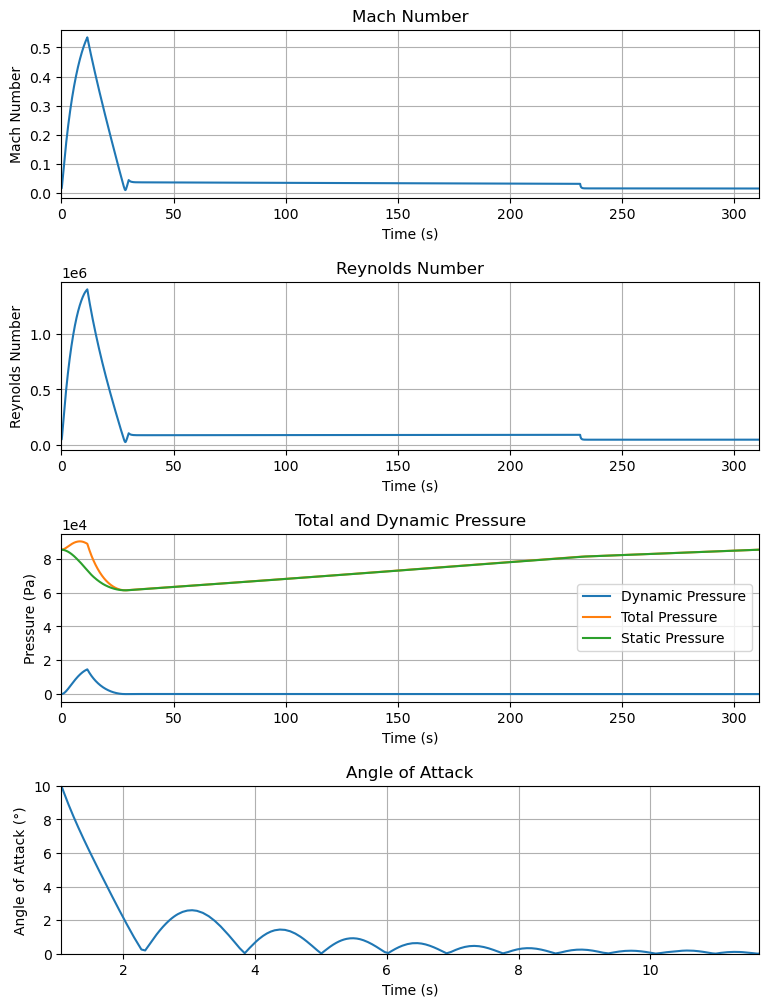



Trajectory Stability and Control Plots



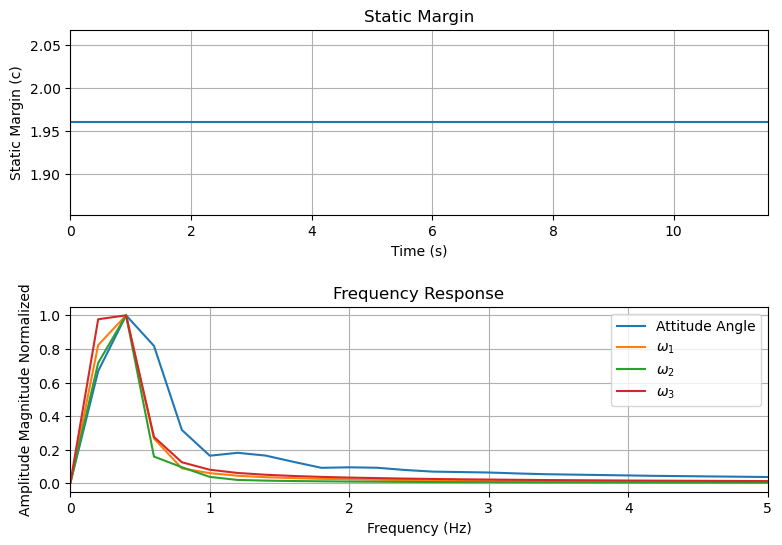



Rocket and Parachute Pressure Plots



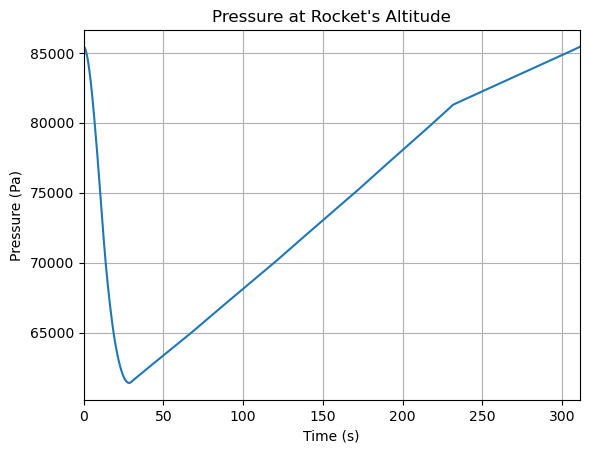


Parachute:  main


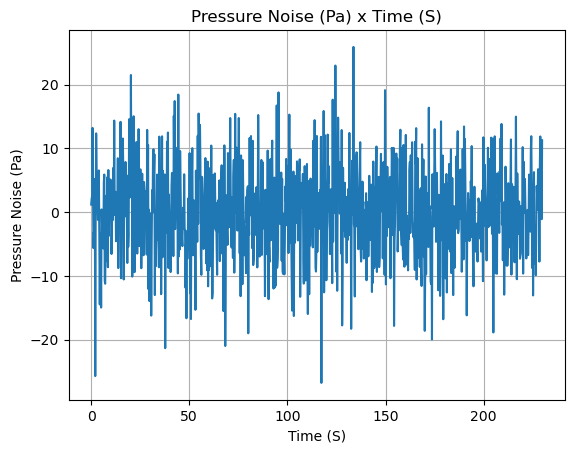

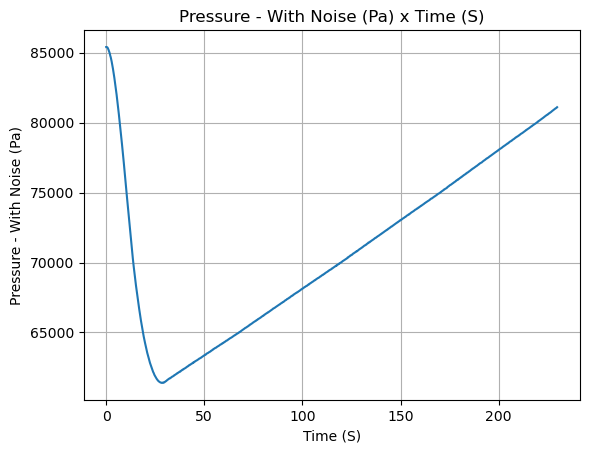

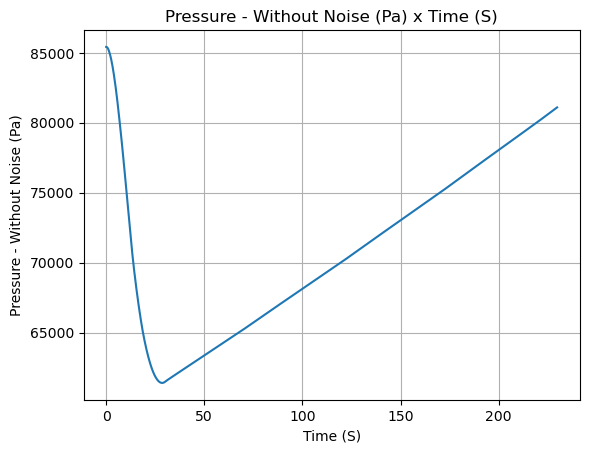


Parachute:  drogue


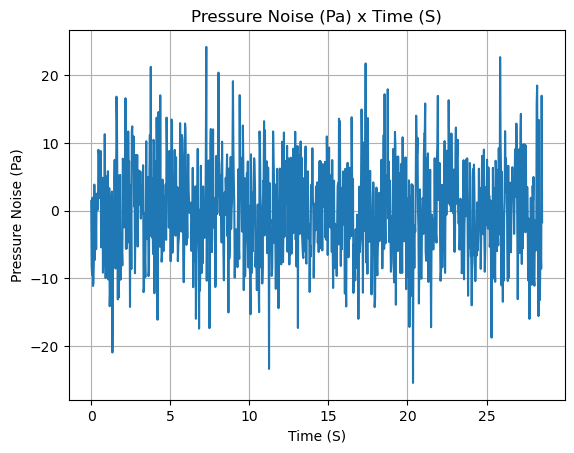

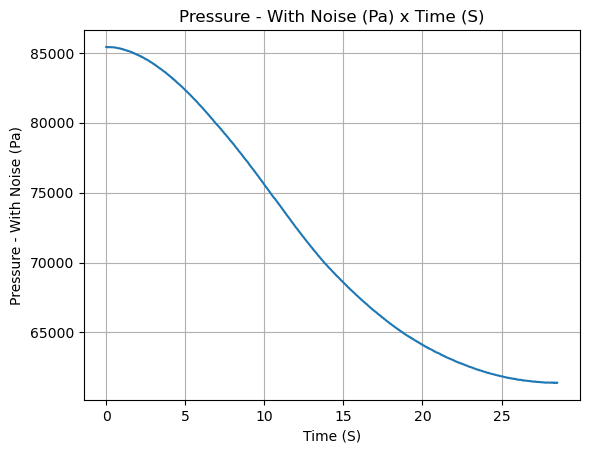

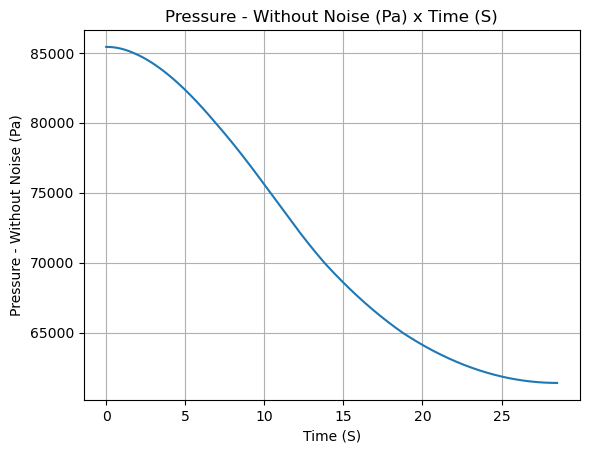

In [25]:
test_flight.all_info()

In [26]:
test_flight.export_kml(
    file_name="AlulaTestFlight.kml",
    extrude=True,
    altitude_mode="relativetoground",
) #Import kml file to Google Earth!

File  AlulaTestFlight.kml  saved with success!


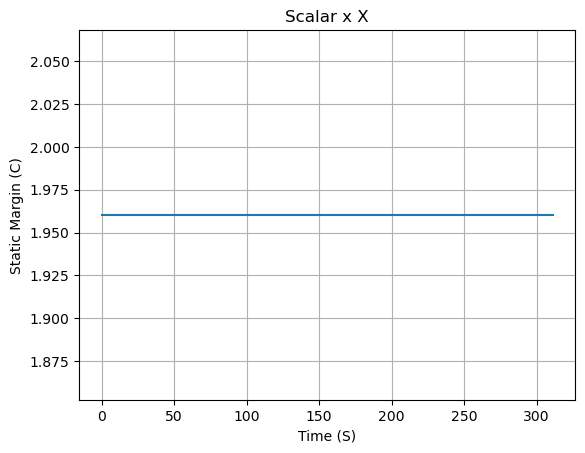

[1.96033542 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542
 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542
 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542
 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542
 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542
 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542
 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542
 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542 1.96033542
 1.96033542 1.96033542]


In [27]:
# Plot & Print static margin for entire flight
test_flight.static_margin.plot(0, test_flight.t_final)
print(test_flight.static_margin(np.linspace(0, test_flight.t_final))) 